# 1. Install & Import Required Libraries

In [1]:
! python -m spacy download en_core_web_sm 

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------- ----------------- 7.3/12.8 MB 50.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# English language model en_core_web_sm used by spaCy for: Tokenization, POS tagging, Lemmatization and Named Entity Recognition (NER)
#! python -m spacy download en_core_web_sm 
#! pip install scikit-learn
#!pip install textblob
# %pip install torch
# %pip install transformers
# %pip install wordcloud
# %pip install transformers umap-learn 

# Standard libraries
import os
import io
from tqdm import tqdm
from tqdm.auto import tqdm
import joblib
import dill
from __future__ import annotations
from pathlib import Path
from typing import List
import torch
from torch.utils.data import DataLoader, Dataset

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
import sklearn

# NLP
import re
import string
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
# from textblob import TextBlob
from collections import Counter
import spacy
from spacy.tokens import Doc
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModel, AutoTokenizer

# Download required resources
nltk.download('stopwords') # for stopword lists
nltk.download('punkt',  force=True)
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet') # for lemmatization
nltk.download('averaged_perceptron_tagger') # for POS tagging
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Sheng
[nltk_data]     Miao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sheng Miao\AppData\Roaming\nltk_data...
[nlt

True

# 2. Load Data

Define the Table and Load into DataFrame

In [3]:
path = "../data/10kPatients_cohort_full_features_2025_08_22_0228.csv"

df = pd.read_csv(path)

In [4]:
df['readmit_30days'].value_counts()

readmit_30days
0    8768
1    1421
Name: count, dtype: int64

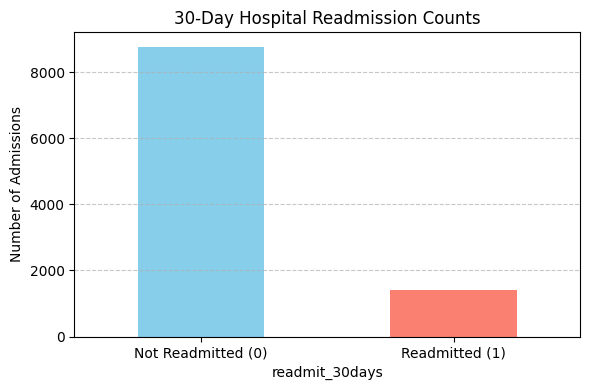

In [5]:
# Count the values
counts = df['readmit_30days'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Labels and title
plt.xticks(ticks=[0, 1], labels=['Not Readmitted (0)', 'Readmitted (1)'], rotation=0)
plt.ylabel('Number of Admissions')
plt.title('30-Day Hospital Readmission Counts')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [6]:
print(len(df))

10189


# 3. Data cleaning / typing

## 3.1 Duration Feature Generation

In [7]:
# Ensure datetime dtypes (force a consistent tz to avoid mixed types)
date_cols = ['admittime','dischtime','icu_intime','icu_outtime']
df.loc[:, date_cols] = df[date_cols].apply(
    lambda s: pd.to_datetime(s, errors='coerce', utc=True)
)

# 2) Compute Timedelta
df['length_of_icu_stay'] = df['icu_outtime'] - df['icu_intime']
df['admit_to_disch'] = df['dischtime'] - df['admittime']

# 3) Hours (no .dt needed)
df['length_of_icu_stay_hours'] = df['length_of_icu_stay'] / pd.Timedelta(hours=1)
df['admit_to_disch_hours'] = df['admit_to_disch'] / pd.Timedelta(hours=1)

# cleanups
df.loc[df['length_of_icu_stay_hours'] < 0, 'length_of_icu_stay_hours'] = np.nan  # bad clocks
df.loc[df['admit_to_disch_hours'] < 0, 'admit_to_disch_hours'] = np.nan  # bad clocks

In [8]:
print(df['length_of_icu_stay_hours'].isna().sum())
print(df['admit_to_disch_hours'].isna().sum())

7729
0


Plot distribution

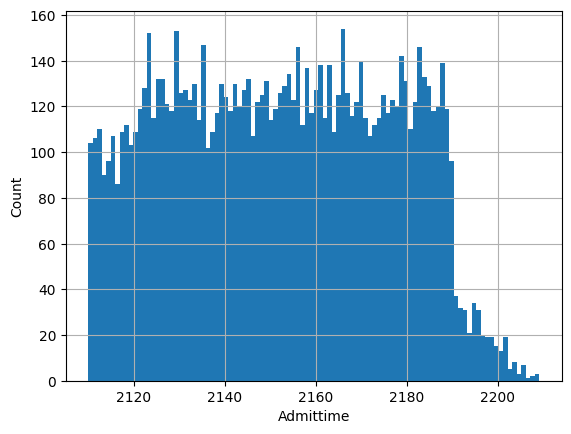

In [9]:
df.admittime.hist(bins=100)
plt.xlabel('Admittime')
plt.ylabel('Count')
plt.show()

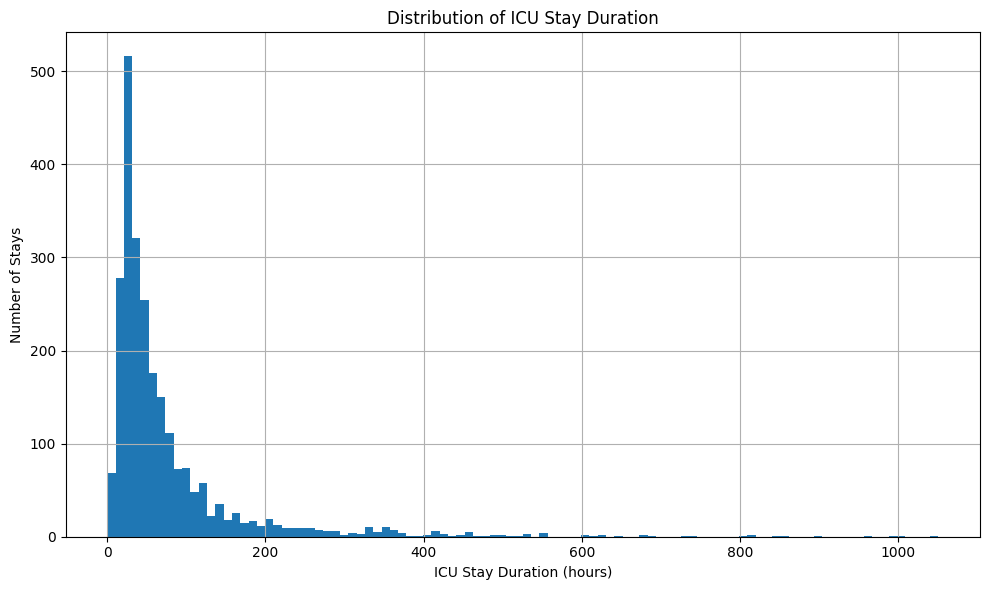

In [10]:
# Convert timedelta to hours (or use .dt.days for days)

plt.figure(figsize=(10, 6))
df['length_of_icu_stay_hours'].hist(bins=100)
plt.xlabel('ICU Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of ICU Stay Duration')
plt.tight_layout()
plt.show()


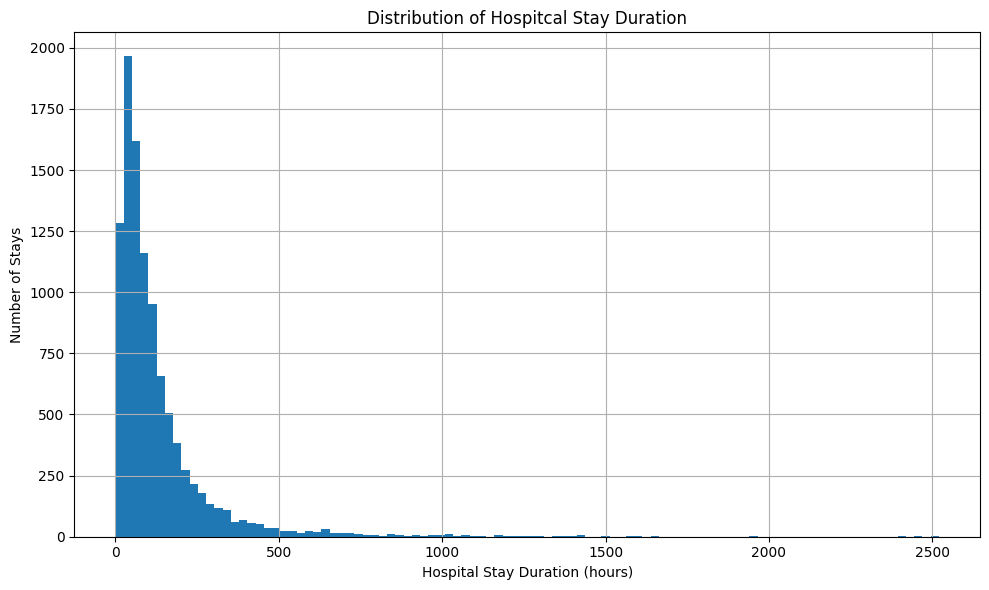

In [11]:
# Convert timedelta to hours (or use .dt.days for days)
plt.figure(figsize=(10, 6))
df['admit_to_disch_hours'].hist(bins=100)
plt.xlabel('Hospital Stay Duration (hours)')
plt.ylabel('Number of Stays')
plt.title('Distribution of Hospitcal Stay Duration')
plt.tight_layout()
plt.show()

These plots show that the majority of hospital and ICU stays are relatively short, with most ICU stays lasting under 200 hours (~8 days) and hospital stays under 500 hours (~20 days). Both distributions are highly right-skewed, indicating that a small number of patients experienced significantly longer stays. The frequency drops sharply as the duration increases, with a few outliers extending well beyond 1,000 hours.

In [12]:
missing_tbl = (
    df.isna().sum()
      .to_frame('n_missing')
      .assign(pct_missing=lambda x: x['n_missing'] / len(df))
      .query('n_missing > 0')
      .sort_values('n_missing', ascending=False)
)
print(missing_tbl)


                                  n_missing  pct_missing
sbp_art_mean                           9081     0.891255
dbp_art_mean                           9079     0.891059
map_art_mean                           9072     0.890372
ex_peripheral_vascular_disorders       8620     0.846010
ex_cardiac_arrhythmias                 8620     0.846010
...                                     ...          ...
insurance                               207     0.020316
language                                 25     0.002454
dx_count                                  3     0.000294
dx_code_uniq                              3     0.000294
dx_root3_uniq                             3     0.000294

[111 rows x 2 columns]


In [13]:
# Count how many rows per subject
row_counts = df['subject_id'].value_counts()

# Subjects with only 1 row
subjects_with_1r = row_counts[row_counts == 1]
# Subjects with 2 rows
subjects_with_2r = row_counts[row_counts == 2]
# Subjects with 3 or more rows
subjects_with_3plusr = row_counts[row_counts >= 3]

print(f"Subjects with only 1 row: {len(subjects_with_1r)}")
print(f"Subjects with 2 rows: {len(subjects_with_2r)}")
print(f"Subjects with 3+ rows: {len(subjects_with_3plusr)}")

Subjects with only 1 row: 9828
Subjects with 2 rows: 157
Subjects with 3+ rows: 15


In [14]:
# Make sure only one note for each patient
# Count number of unique hadm_ids per subject_id
note_counts = df.groupby('subject_id')['note_id'].nunique()
note_multi = note_counts[note_counts > 1].index.tolist()
print(note_multi)
print(len(note_multi))

[]
0


In [15]:
# Make sure only one note for each patient
# Count number of unique hadm_ids per subject_id
icu_counts = df.groupby('subject_id')['icu_stay_id'].nunique()
icu_multi = icu_counts[icu_counts > 1].index.tolist()
print(icu_multi)
print(len(icu_multi))

[10020740, 10029291, 10034317, 10063848, 10089085, 10100037, 10100435, 10104730, 10110133, 10110863, 10123036, 10131647, 10132888, 10145374, 10176458, 10180134, 10193074, 10206502, 10206723, 10209126, 10209410, 10213275, 10219697, 10227155, 10233597, 10244629, 10246901, 10247095, 10250582, 10258162, 10264113, 10268465, 10275937, 10284532, 10298894, 10300586, 10302157, 10304339, 10306162, 10308297, 10313200, 10319938, 10350488, 10358380, 10373447, 10388400, 10390732, 10395553, 10411115, 10417530, 10427193, 10431886, 10431934, 10438253, 10463621, 10471192, 10481582, 10488906, 10495665, 10504004, 10507163, 10515638, 10526134, 10537484, 10541842, 10552915, 10556676, 10569076, 10575383, 10582595, 10597337, 10606965, 10613188, 10623984, 10624561, 10634251, 10643827, 10644961, 10656173, 10658571, 10679181, 10691194, 10693162, 10703777, 10709195, 10710573, 10723263, 10724174, 10725525, 10760122, 10773491, 10781714, 10806973, 10813367, 10819468, 10830347, 10835819, 10839821, 10840912, 10845634,

In [16]:
# 1) Sample this patient's rows (use .copy()!)
patient_sample = df.loc[df['subject_id'] == 10020740, :].copy()

# 2) Drop columns that are identical across all of this patient’s rows
#    (treats NaN as a value; all-NaN columns are dropped too)
const_mask = patient_sample.nunique(dropna=False) <= 1
patient_var = patient_sample.loc[:, ~const_mask]

# (optional) see what got dropped
dropped_cols = patient_sample.columns[const_mask].tolist()
print("Dropped constant columns:", dropped_cols)

patient_var

Dropped constant columns: ['row_grain', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'note_id', 'note_text', 'rn', 'next_hadm_id', 'next_admittime', 'next_admission_type', 'days_to_next_admit', 'readmit_30days', 'icu_stay_count', 'dx_count', 'dx_code_uniq', 'dx_root3_uniq', 'proc_count', 'proc_code_uniq', 'proc_root3_uniq', 'cci_mi', 'cci_chf', 'cci_pvd', 'cci_cevd', 'cci_dementia', 'cci_copd', 'cci_rheum', 'cci_pud', 'cci_mild_liver', 'cci_diabetes_wo_comp', 'cci_diabetes_w_comp', 'cci_hemiplegia', 'cci_renal', 'cci_any_cancer', 'cci_metastatic_solid', 'cci_severe_liver', 'cci_aids', 'cci_score', 'ex_congestive_heart_failure', 'ex_cardiac_arrhythmias', 'ex_valvular_disease', 'ex_pulmonary_circulation', 'ex_peripheral_vascular_disorders', 'ex_hypertension_uncomplicated', 'ex_hypertension_complicated', 'ex_paralysis', 'ex_other_neurological', 'ex_chronic_pulmonary', 'ex

,grain_id,icu_stay_id,icu_intime,icu_outtime,hr_mean,rr_mean,spo2_mean,temp_c_mean,map_mean_pref,map_ni_mean,sbp_ni_mean,dbp_ni_mean,length_of_icu_stay,length_of_icu_stay_hours
3218,35044342,35044342.0,2150-03-19 04:41:33+00:00,2150-03-23 20:49:33+00:00,102.163636,29.110092,95.936364,37.011905,84.730769,84.730769,131.278846,70.644231,4 days 16:08:00,112.133333
3310,35026312,35026312.0,2150-03-11 15:34:56+00:00,2150-03-19 02:17:47+00:00,86.994536,21.837989,96.653179,36.951537,77.460674,77.460674,122.325843,64.359551,7 days 10:42:51,178.714167
3314,35889503,35889503.0,2150-03-25 18:22:56+00:00,2150-03-28 22:20:47+00:00,105.935065,28.272727,97.324675,37.446860,84.184211,84.184211,128.460526,70.934211,3 days 03:57:51,75.964167
3497,31077365,31077365.0,2150-03-30 07:57:10+00:00,2150-04-04 10:58:43+00:00,98.925926,22.296296,97.490683,37.259857,81.360902,81.360902,123.466165,69.383459,5 days 03:01:33,123.025833


In [17]:
# Count how many admissions per subject
admit_counts = df.groupby('subject_id')['hadm_id'].nunique()
subjects_with_1 = admit_counts[admit_counts == 1]
subjects_with_2 = admit_counts[admit_counts == 2]
subjects_with_3plus = admit_counts[admit_counts >= 3]

print(f"Subjects with only 1 admission: {len(subjects_with_1)}")
print(f"Subjects with 2 admissions: {len(subjects_with_2)}")
print(f"Subjects with 3+ admissions: {len(subjects_with_3plus)}")


Subjects with only 1 admission: 10000
Subjects with 2 admissions: 0
Subjects with 3+ admissions: 0


This counts the number of rows per subject_id doesn't equal to the number of distinct hospital admissions (hadm_id). The count of subjects with only 1 admission (8732) is more than that of subjects with only 1 row (8615)，indicating that few subject with only one admission have two rows, which could be due to more than one icu_id at same hadm_id.

In [18]:
# Make sure only one admission was selected for each patient
# Count number of unique hadm_ids per subject_id
hadm_counts = df.groupby('subject_id')['hadm_id'].nunique()
subjects_multi = hadm_counts[hadm_counts > 1].index.tolist()
print(subjects_multi)
print(len(subjects_multi))

[]
0


# 4. Clinical Note Data EDA

## 4.1 Basic statistics

In [19]:
df['note_length'] = df['note_text'].apply(len)
df['word_count'] = df['note_text'].apply(lambda x: len(x.split()))

In [20]:
df[['note_length','word_count']].head()

,note_length,word_count
0,7037,1011
1,8272,1217
2,4465,694
3,10434,1558
4,9723,1431


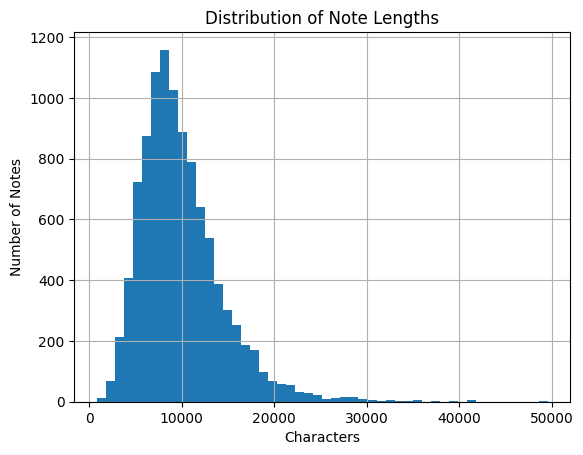

In [21]:
# Histogram
df['note_length'].hist(bins=50)
plt.title("Distribution of Note Lengths")
plt.xlabel("Characters")
plt.ylabel("Number of Notes")
plt.show()

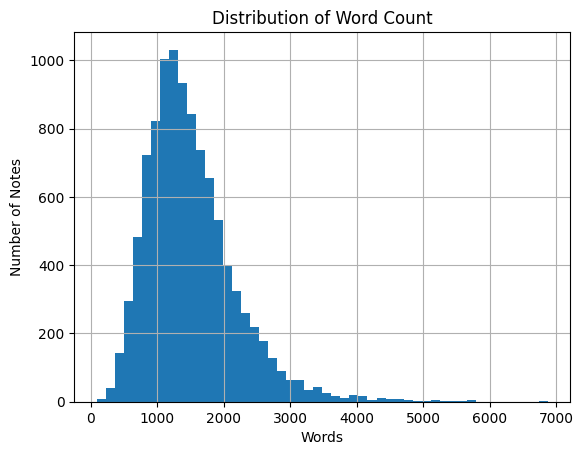

In [22]:
# Histogram
df['word_count'].hist(bins=50)
plt.title("Distribution of Word Count")
plt.xlabel("Words")
plt.ylabel("Number of Notes")
plt.show()

## 4.2 Check for duplicates

In [23]:
# check for duplicate discharge notes for the same patient (subject_id) and hospital admission (hadm_id).
df.duplicated(subset=['subject_id', 'hadm_id', 'note_text']).sum()


np.int64(189)

In [24]:
dup_df = df[df.duplicated(subset=['subject_id', 'hadm_id', 'note_text'], keep=False)]
dup_df = dup_df.sort_values(by=['subject_id', 'hadm_id'])
dup_df[['subject_id', 'hadm_id', 'note_id']].head()

,subject_id,hadm_id,note_id
3218,10020740,23831430,10020740-DS-17
3310,10020740,23831430,10020740-DS-17
3314,10020740,23831430,10020740-DS-17
3497,10020740,23831430,10020740-DS-17
1584,10029291,22205327,10029291-DS-17


In [25]:
# for (subject, hadm), group in dup_df.groupby(['subject_id', 'hadm_id']):
#     print(f"\n🔹 subject_id: {subject}, hadm_id: {hadm}, count: {len(group)}")
#     display(group)

After run the code cell above to inspect the duplicates within each group, it appears that the duplicated records correspond to different ICU stay_ids for the same patient within the same hadm_id. Most groups have two distinct stay_ids, while a few have three. 

## 4.3 Frequent words or terms

In [26]:
# Loads a list of common English stopwords (e.g., "the", "is", "and") using nltk and converts it to a set for faster lookup
# Base stopwords
stop_words = set(stopwords.words('english'))

def tokenize(text):
    # Lowercase and tokenize using regex
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [word for word in tokens if word not in stop_words and word not in string.punctuation]

# .explode() flattens the list into a single column of words, one per row — so now all_words is a Series of individual words across all notes.
all_words = df['note_text'].apply(tokenize).explode() 

# Count the frequency of each word in the exploded Series using Counter, and returns the 20 most common words as a list of tuples (word, count)
Counter(all_words).most_common(20)

[('___', 542766),
 ('1', 153754),
 ('mg', 137026),
 ('2', 125404),
 ('po', 109807),
 ('0', 99180),
 ('blood', 94293),
 ('3', 93617),
 ('5', 92837),
 ('discharge', 90039),
 ('4', 84489),
 ('daily', 83535),
 ('patient', 79138),
 ('pain', 78688),
 ('tablet', 76083),
 ('history', 63228),
 ('6', 57082),
 ('8', 52810),
 ('left', 52568),
 ('7', 49076)]

'mg', 'tablet', and numbers like '1', '2' are common — expected in medication instructions. 'patient', 'discharge', 'history' are frequent medical terms in discharge summaries.
To improve quality:
1. add '__', digits ('1', '2'...), and 'mg', 'tablet' to a custom stopword list since they aren't meaningful for modeling, 
2. apply POS-aware lemmatization (reduce "patients" to "patient", "was" to "be") for better generalization and accuracy.

# 5. Text Processing (Cleaning, Tokenization and Lemmatization)

## 5.1 Advanced spaCy Batch Processing Pipeline

In [27]:
# 1. Let SpaCy do more work in C
# disable all but the tokenizer+lemmatizer
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# Prepare stopwords and punctuation
nltk_stopwords = set(stopwords.words('english'))
custom_stopwords = nltk_stopwords.union({'__', '___', '____', 'mg', 'tablet', 'po', 'x', 'bid', 'prn'})
punctuations = set(string.punctuation)

results = []

for doc in tqdm(nlp.pipe(df['note_text'], batch_size=200, n_process=1), total=len(df['note_text'])):
    
    # vectorized C call to get all lemmas in one shot
    lemmas_ids = doc.to_array("LEMMA")
    # filter and lowercase in bulk
    lemma_strings = [nlp.vocab.strings[lemma_id].lower() for lemma_id in lemmas_ids]
    filtered_lemmas = [lemma for lemma in lemma_strings
              if lemma.isalpha() and lemma not in custom_stopwords]
    
    results.append(filtered_lemmas)

df['advanced_spacy_lemmas'] = results

#37m 37.2s

  0%|          | 0/10189 [00:00<?, ?it/s]

For CPU-only, single-core, full lemmatization of clinical or long texts, the speed is reasonable. Especially because:
- spaCy loads full vocab
- Lemmatization requires morphological analysis
- I'm filtering, converting to strings, lowercasing, and checking stopwords

## 5.2 Lemma-based Visualizations

### 5.2.1 Bar Plot of Most Frequent Lemmas

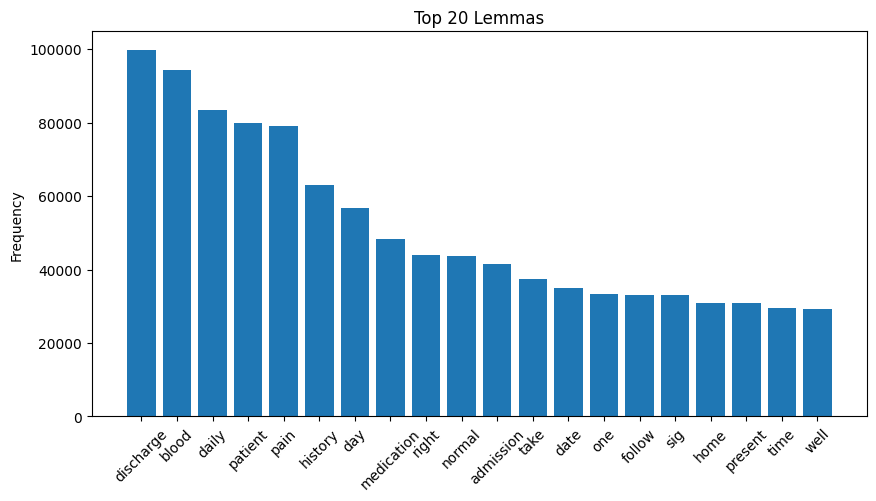

In [28]:
from collections import Counter
import matplotlib.pyplot as plt

all_lemmas = df['advanced_spacy_lemmas'].explode()  
freq = Counter(all_lemmas)
common = freq.most_common(20)

words, counts = zip(*common)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Lemmas")
plt.ylabel("Frequency")
plt.show()


### 5.2.2 Word Cloud

In [29]:
#%pip install wordcloud

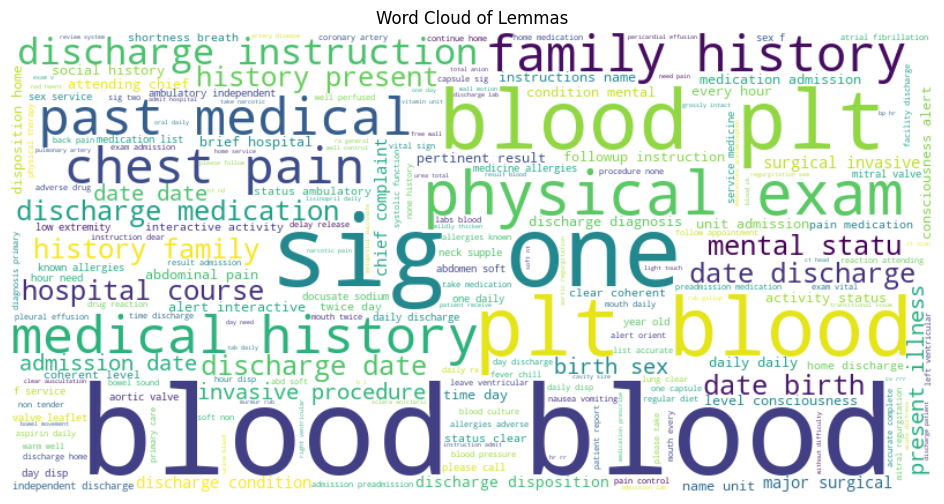

In [30]:
from wordcloud import WordCloud

text = " ".join(all_lemmas)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Lemmas")
plt.show()


# 6. Text Feature Extraction

## 6.1 Extract TF-IDF vectors from selected lemma column (e.g., 'advanced_spacy_lemmas')

In [31]:
# 1. Join token lists into strings (required by TfidfVectorizer)
df['lemma_text'] = df['advanced_spacy_lemmas'].apply(lambda lemmas: ' '.join(lemmas))

# 2. Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    lowercase=False,   # Tokens are already cleaned
    # Out of all the tokens (or n-grams) across the entire corpus, keep only the top 1,000 most frequent ones (by TF-IDF score).
    max_features=2000, # Adjust as needed
    ngram_range=(1, 2) # Unigrams and bigrams
)

# 3. Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['lemma_text'])

# 4. Convert to DataFrame for inspection

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.shape

(10189, 2000)

In [32]:
tfidf_df.head()

,ab,abd,abd soft,abdomen,abdomen pelvis,abdomen soft,abdominal,abdominal pain,ability,able,...,xl daily,year,year ago,year old,yeast,yeast none,yellow,yes,yesterday,yo
0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.025641,0.000000,0.0,0.000000,...,0.000000,0.023163,0.0,0.029897,0.00000,0.000000,0.000000,0.0,0.00000,0.0
1,0.0,0.000000,0.000000,0.015427,0.0,0.020884,0.000000,0.000000,0.0,0.000000,...,0.067618,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.03121,0.0
2,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.032448,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.0
3,0.0,0.014277,0.018815,0.000000,0.0,0.000000,0.095443,0.093641,0.0,0.000000,...,0.000000,0.024634,0.0,0.031796,0.00000,0.000000,0.022461,0.0,0.00000,0.0
4,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.017700,...,0.000000,0.013878,0.0,0.000000,0.05312,0.055659,0.025306,0.0,0.00000,0.0


In [57]:
# Merge TF-IDF Features to Structured Data
tfidf_str = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

## 6.2 Transformer-Based Word Embedding (ClinicalBERT)

In [34]:
# --- Make the project root importable ---------------------------------
import sys, pathlib

package_parent = pathlib.Path.cwd().parents[1]          # two levels up from notebooks/
if str(package_parent) not in sys.path:             # keep sys.path tidy
    sys.path.insert(0, str(package_parent))

In [35]:
# Assume df already has a "lemmas" column
from Mimic_Readmit_Clinbert.utils.embeddings import add_clinbert_embeddings

clinbert_df = add_clinbert_embeddings(df, text_col="advanced_spacy_lemmas", batch_size=32)
print(clinbert_df.shape)  # original cols + 768 embedding cols

#56m 25.4s

ClinicalBERT:   0%|          | 0/10189 [00:00<?, ?it/s]

(10189, 768)


visualize ClinicalBERT (or any BERT) embeddings using t-SNE or UMAP

In [36]:
# %pip install transformers umap-learn 

In [37]:
# from transformers import AutoTokenizer, AutoModel
# from sklearn.manifold import TSNE
# import umap

# # ─────────────── 1. Load ClinicalBERT Model ───────────────
# MODEL_NAME = "emilyalsentzer/Bio_ClinicalBERT"
# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# model = AutoModel.from_pretrained(MODEL_NAME)
# model.eval().cpu()  # use .cuda() if GPU

# # ─────────────── 2. Define BERT Embedding Function ───────────────
# @torch.no_grad()
# def get_cls_embeddings(texts, max_len=128):
#     """Return CLS token embeddings from BERT for a list of texts."""
#     inputs = tokenizer(
#         texts, 
#         padding=True, 
#         truncation=True, 
#         max_length=max_len, 
#         return_tensors="pt"
#     )
#     inputs = {k: v.cuda() for k, v in inputs.items()}  # remove if using CPU
#     outputs = model(**inputs)
#     cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
#     return cls_embeddings.cpu().numpy()

# # ─────────────── 3. Sample & Embed Text ───────────────
# # Convert lemmas into strings (if not already)
# df["lemmas_str"] = df["lemmas"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
# df_sample = df.sample(n=500, random_state=42)  # keep it small for t-SNE

# texts = df_sample["lemmas_str"].tolist()
# labels = df_sample["readmit_30days"].tolist()

# embeddings = get_cls_embeddings(texts)

# # ─────────────── 4A. t-SNE ───────────────
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(embeddings)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette=["skyblue", "salmon"])
# plt.title("t-SNE of ClinicalBERT Embeddings")
# plt.xlabel("Component 1")
# plt.ylabel("Component 2")
# plt.legend(title="Readmitted")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # ─────────────── 4B. UMAP ───────────────
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
# X_umap = reducer.fit_transform(embeddings)

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette=["skyblue", "salmon"])
# plt.title("UMAP of ClinicalBERT Embeddings")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.legend(title="Readmitted")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [58]:
# Merge ClinicalBERT embedding to Structured Data
clinbert_str = pd.concat([df.reset_index(drop=True), clinbert_df.reset_index(drop=True)], axis=1)

In [59]:
# Merge fuse structured variables + TF-IDF features + transformer embeddings
tfidf_clinbert_str = pd.concat([tfidf_str.reset_index(drop=True), clinbert_df.reset_index(drop=True)], axis=1)

Only keep the same columns as that of my first modeling effort.

In [60]:
# your keep list from the structured DF
cols_selected = [
    "subject_id","hadm_id","icu_stay_id","admittime","dischtime",
    "icu_intime","icu_outtime","note_id","note_text",
    "length_of_icu_stay","admit_to_disch",
    "length_of_icu_stay_hours","admit_to_disch_hours",
    "next_admittime","days_to_next_admit","readmit_30days"
]

# columns from each source
struct_keep   = [c for c in cols_selected if c in tfidf_clinbert_str.columns]
tfidf_cols    = list(tfidf_df.columns)
clinbert_cols = list(clinbert_df.columns)

# build final column list (dedupe while preserving order)
from collections import OrderedDict
tfidf_strkept_cols = list(OrderedDict.fromkeys(struct_keep + tfidf_cols))
clinbert_strkept_cols = list(OrderedDict.fromkeys(struct_keep + clinbert_cols))
tfidf_clinbert_strkept_cols = list(OrderedDict.fromkeys(struct_keep + tfidf_cols + clinbert_cols))

# new dataframe
tfidf_strkept = tfidf_clinbert_str.loc[:, tfidf_strkept_cols].copy()
clinbert_strkept = tfidf_clinbert_str.loc[:, clinbert_strkept_cols].copy()
tfidfbert_strkept = tfidf_clinbert_str.loc[:, tfidf_clinbert_strkept_cols].copy()

# (optional) see which structured columns were dropped
dropped_struct = [c for c in df.columns if c not in struct_keep]
print("Dropped structured cols number:", len(dropped_struct))
print("Kept structured cols number:", len(cols_selected))
print("tfidf_cols cols number:", len(tfidf_cols))
print("clinbert_cols cols number:", len(clinbert_cols))
print("\ntfidf_strkept_cols cols number:", len(tfidf_strkept_cols))
print("clinbert_strkept_cols cols number:", len(clinbert_strkept_cols))
print("tfidf_clinbert_strkept_cols cols number:", len(tfidf_clinbert_strkept_cols))
print('\n')
print(tfidf_clinbert_str.shape)
print(tfidf_strkept.shape)
print(clinbert_strkept.shape)
print(tfidfbert_strkept.shape)

Dropped structured cols number: 117
Kept structured cols number: 16
tfidf_cols cols number: 2000
clinbert_cols cols number: 768

tfidf_strkept_cols cols number: 2016
clinbert_strkept_cols cols number: 784
tfidf_clinbert_strkept_cols cols number: 2784


(10189, 2901)
(10189, 2017)
(10189, 784)
(10189, 2785)


In [61]:
print(tfidf_str.shape)
print(clinbert_str.shape)
print(tfidf_clinbert_str.shape)

(10189, 2133)
(10189, 901)
(10189, 2901)


In [62]:
print("\ntfidf_strkept_cols cols number:", len(tfidf_strkept_cols))
print("tfidf_clinbert_strkept_cols cols number:", len(tfidf_clinbert_strkept_cols))
print(tfidf_strkept.shape)
print(tfidfbert_strkept.shape)


tfidf_strkept_cols cols number: 2016
tfidf_clinbert_strkept_cols cols number: 2784
(10189, 2017)
(10189, 2785)


Here, I found there is inconsistence of column number of new dataframe with the column number of columns list used to slide. It usually because the orginal dataframe (tfidf_clinbert_str) has duplicate column names.When a DataFrame has duplicates and you select with duplicates, pandas returns all columns with the same column name, so the result can have more columns than the number of names in column list.The +1 mismatch means there’s exactly one duplicated name among the columns you’re selecting. 

In [63]:
cols = tfidf_clinbert_str.columns
dupes = cols[cols.duplicated(keep=False)]          # all duplicated labels
print(dupes.unique())                              # which names are duplicated?
print(dupes.value_counts())                        # how many times each appears


Index(['language'], dtype='object')
language    2
Name: count, dtype: int64


Remove duplicate columns (keep first occurrence):

In [64]:
# Remove duplicate columns (keep first occurrence):
df_nodup = tfidf_clinbert_str.loc[:, ~tfidf_clinbert_str.columns.duplicated()].copy()
# Re-select
tfidf_strkept = df_nodup.loc[:, tfidf_strkept_cols].copy()
tfidfbert_strkept = df_nodup.loc[:, tfidf_clinbert_strkept_cols].copy()

print("\ntfidf_strkept_cols cols number:", len(tfidf_strkept_cols))
print("tfidf_clinbert_strkept_cols cols number:", len(tfidf_clinbert_strkept_cols))
print(tfidf_strkept.shape)
print(tfidfbert_strkept.shape)


tfidf_strkept_cols cols number: 2016
tfidf_clinbert_strkept_cols cols number: 2784
(10189, 2016)
(10189, 2784)


# 7. Save Dataset and Variables

Save df DataFrame into csv file

In [65]:
from pathlib import Path

root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
data_dir = root_dir / "data"
data_dir.mkdir(exist_ok=True)         # create folder if missing

df.to_csv               (data_dir / "cleaned_lemmas_2.csv",    index=False)  # Structured data 
tfidf_df.to_csv         (data_dir / "tfidf_2.csv",             index=False)   # tfidf only
clinbert_df.to_csv      (data_dir / "clinbert_2.csv",       index=False)   # clinbert only

tfidf_str.to_csv   (data_dir / "tfidf_str_2.csv",    index=False)   # tfidf + structured data
clinbert_str.to_csv(data_dir / "clinbert_str_2.csv", index=False)   # clinbert + structured data
tfidf_clinbert_str.to_csv   (data_dir / "tfidf_clinbert_str_2.csv",    index=False)   # tfidf + clinbert + structured data

tfidf_strkept.to_csv   (data_dir / "tfidf_strkept_2.csv",    index=False)   # tfidf + seleted cols in Structured data
clinbert_strkept.to_csv(data_dir / "clinbert_strkept_2.csv", index=False)   # clinbert + seleted cols in Structured data
tfidfbert_strkept.to_csv   (data_dir / "tfidf_clinbert_strkept_2.csv",    index=False)  # tfidf + clinbert + seleted cols in Structured data

Structured EHR variables, TF-IDF on raw or lemmatised notes, and ClinicalBERT CLS/pooled embeddings, the three channels emphasise different statistical signals, stacking them side-by-side (early fusion) or training separate models and ensemble-combining outputs (late fusion) often yields small-to-moderate AUC gains in clinical-NLP papers.

Save only selected important variables

In [66]:
EDA_session = {
    'df': df,                        
    'tfidf_df': tfidf_df,
    'clinbert_df':clinbert_df,

    'tfidf_str': tfidf_str, 
    'tfidf_vectorizer': tfidf_vectorizer,
    'clinbert_str': clinbert_str,
    'tfidf_clinbert_str':tfidf_clinbert_str,

    "tfidf_strkept": tfidf_strkept,
    "clinbert_strkept": clinbert_strkept,
    "tfidfbert_strkept": tfidfbert_strkept,

}

joblib.dump(EDA_session, data_dir/'EDA_session_2.joblib')

['c:\\Users\\Sheng Miao\\OneDrive\\桌面\\DS\\Capstone projects\\Mimic_Readmit_Clinbert\\data\\EDA_session_2.joblib']

Resuming work

In [ ]:
# root_dir = Path.cwd().parent          # notebooks → mimic_readmit_clinbert
# data_dir = root_dir / "data"
# data_dir.mkdir(exist_ok=True)         # create folder if missing

# session_data = joblib.load(data_dir/"EDA_session_2.joblib")
# _ = session_data['_']